In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Run experiments

cd OPTWIN_PATH/Moa-Experiments/scripts/

./classification_experiments.sh

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
n_itt = 30

In [4]:
OPTWIN_PATH = "" #<-- DEFINE OPTWIN PATH
RESULT_FILE1 = OPTWIN_PATH+"/MOA-Experiments/results/nb_results/"
RESULT_FILE1 += "naive_bayes_AgrawalGenerator_"
RESULT_FILE2 = ".csv"

In [5]:
save_plot = False
PLOT_SAVE_DIR="" #set path to save plot if save_plot=True

In [6]:
def plot_drifts(method, df, true_positives, false_positives, x_axis, y_axis, legend, separate_legend):
    drifts = [20000,40000,60000,80000]
    #df['classifications_correct_(percent)']
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(6,2.5))
    plt.title(method, fontsize = 20)
    if y_axis:
        plt.ylabel('Accuracy') 
    if x_axis:
        plt.xlabel('Stream datapoints') 
    
    for d in drifts:
        plt.vlines(d, 50, 65, colors = "black", linewidth=2)
        #plt.text(d+500, 80, "Drift", c = "black", fontsize = 10)
    
    for tp in true_positives:
        plt.vlines(tp, 50, 68, colors = "green", linewidth=1, linestyles = "dashed")
        #plt.text(d+500, 80, "Drift", c = "blue", fontsize = 10)
    
    
    for fp in false_positives:
        plt.vlines(fp, 69, 80, colors = "red", linewidth=1, linestyles = "dashed")
        #plt.text(d+500, 80, "Drift", c = "blue", fontsize = 10)
    
    if len(drifts) > 0 : plt.vlines(drifts[0], 0, 65, colors = "black", linewidth=2, label = "Drift")
    if len(true_positives) > 0 : plt.vlines(true_positives[0], 0, 68, colors = "green", linewidth=1, linestyles = "dashed", label = "TP")
    if len(false_positives) > 0 : plt.vlines(false_positives[0], 69, 80, colors = "red", linewidth=1, linestyles = "dashed", label = "FP")
    
    
    x1,x2,y1,y2 = plt.axis()
    plt.axis((1,99999,50,72))
    #plt.rcParams.update({'font.size': 30})
    
    df['classifications_correct_(percent)'].plot(label='')
    
    if legend:
        plt.legend(loc="lower right")
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'agrawal_'+method.replace(' ', '')+'.svg', bbox_inches="tight") #save plot
        plt.show()
    elif separate_legend:
        plt.legend()
        ax = plt.gca()
        legend_handles, legend_labels = ax.get_legend_handles_labels() #get legends
        plt.gca().legend_ = None #remove legends
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'agrawal_'+method.replace(' ', '')+'.svg', bbox_inches="tight") #save plot
        plt.show() #print plot without legends
        
        legend_figure = plt.figure() 
        plt.plot([], []) #create new empty plot
        plt.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0, 0), ncol=3) #add legends
        plt.axis('off') #remove axis
        plt.subplots_adjust(top=0.01, bottom=0, left=0.1, right=0.2)  # Reduce image size
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'legend.svg', bbox_inches="tight") #save lagend

    else:
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'agrawal_'+method.replace(' ', '')+'.svg', bbox_inches="tight") #save plot
        plt.show()
    
    
    

    

In [7]:
def identify_metrics(method, n_itt, name, itt, x_axis, y_axis, legend, separate_legend):
    output = {}
    output['method'] = method
    #open n_itt results
    drift_detection = []
    for i in range(1,n_itt+1):
        RESULT_FILE = RESULT_FILE1+method+"_"+str(i)+"_"+str(drift_window)+RESULT_FILE2
        df = pd.read_csv(RESULT_FILE, low_memory=False)
        df.columns = [c.replace(' ', '_') for c in df.columns] #remove spaces from column names
        drift_detection.append(df)
        
    #get avg and std from n_itt runs
    drift_detection_concat =  pd.concat(drift_detection)
    drift_detection_concat = drift_detection_concat.drop('Kappa_Statistic_(percent)', axis=1) #remove unused statistic
    drift_detection_concat = drift_detection_concat.drop('Kappa_Temporal_Statistic_(percent)', axis=1) #remove unused statistic
    drift_detection_concat = drift_detection_concat.drop('Kappa_M_Statistic_(percent)', axis=1) #remove unused statistic
    drift_detection_avg = drift_detection_concat.groupby(drift_detection_concat.index).mean(numeric_only=True)
    drift_detection_sdv = drift_detection_concat.groupby(drift_detection_concat.index).std()

    output['avg_accuracy'] = drift_detection_avg['classifications_correct_(percent)'][len(drift_detection_avg.index)-1]
    output['std_accuracy'] = drift_detection_sdv['classifications_correct_(percent)'][len(drift_detection_sdv.index)-1]
    
    output['avg_cpu'] = drift_detection_avg['evaluation_time_(cpu_seconds)'][len(drift_detection_avg.index)-1]
    output['std_cpu'] = drift_detection_sdv['evaluation_time_(cpu_seconds)'][len(drift_detection_sdv.index)-1]
    
    output['avg_ram']  = drift_detection_avg['model_cost_(RAM-Hours)'][len(drift_detection_avg.index)-1]
    output['std_ram']  = drift_detection_sdv['model_cost_(RAM-Hours)'][len(drift_detection_sdv.index)-1]
    
    #get drift delays & true and false positives
    avg_delays = []
    false_positives = []
    true_positives = []
    list_true_positives = [] #index of true positives
    list_false_positives = [] #index of false_positives
    for i in range(len(drift_detection)):
        streams = []
        streams.append(drift_detection[i]['Change_detected'].iloc[:20000])
        streams.append(drift_detection[i]['Change_detected'].iloc[20000:40000])
        streams.append(drift_detection[i]['Change_detected'].iloc[40000:60000])
        streams.append(drift_detection[i]['Change_detected'].iloc[60000:80000])
        streams.append(drift_detection[i]['Change_detected'].iloc[80000:])
        
        
        delay = []
        fp = streams[0].sum()
        tp = 0
        l_true_positives = []
        l_false_positives = streams[0].eq(1).index[streams[0].eq(1)].tolist()
        for s in streams[1:]:
            if s.sum() >= 1: #drift identified in stream interval
                drifts_list = s.eq(1).index[s.eq(1)].tolist()
                drift_init = s.index[0]
                drift_identified = s[s > 0].index[0]
                delay.append(drift_identified - drift_init)
                if drift_identified - drift_init < 10000:
                    tp += 1 #first drift is true
                    l_true_positives.extend([drifts_list[0]])
                    fp += s.sum() - 1 #other drifts are false positives
                    l_false_positives.extend(drifts_list[1:])
                else:
                    fp += s.sum()
                    l_false_positives.extend(drifts_list)

        if len(delay) > 0:
            avg_delay = sum(delay) / len(delay)
            avg_delays.append(avg_delay)
        false_positives.append(fp)
        true_positives.append(tp)
        list_true_positives.append(l_true_positives)
        list_false_positives.append(l_false_positives)
    
    if len(avg_delays) > 0:
        output['avg_delay'] = sum(avg_delays) / len(avg_delays)
    else:
        output['avg_delay'] = 0
    output['std_delay'] = np.std(avg_delays)
    
    output['avg_fp'] = sum(false_positives) / len(false_positives)
    output['std_fp'] = np.std(false_positives)
    
    output['avg_tp'] = sum(true_positives) / len(true_positives)
    output['std_tp'] = np.std(true_positives)
    
    plot_drifts(name, drift_detection[itt], list_true_positives[itt], list_false_positives[itt], x_axis, y_axis, legend, separate_legend)
    
    return output

# ABRUPT DRIFT

In [8]:
drift_window = 1

### OPTWIN -r 0.1

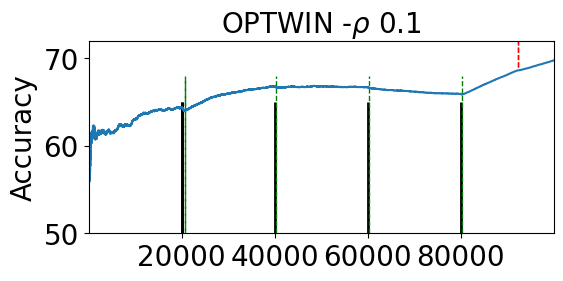

{'method': '(OPTWIN-r0.1)',
 'avg_accuracy': 70.1126,
 'std_accuracy': 0.276642754817658,
 'avg_cpu': 45.35050083333333,
 'std_cpu': 1.2822039417297253,
 'avg_ram': 4.693859832430491e-08,
 'std_ram': 1.325119198553127e-09,
 'avg_delay': 371.6166666666667,
 'std_delay': 45.59448675248162,
 'avg_fp': 0.6333333333333333,
 'std_fp': 0.6574360974438673,
 'avg_tp': 4.0,
 'std_tp': 0.0}

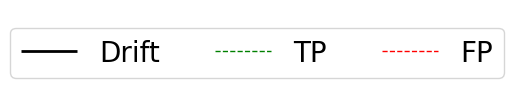

In [9]:
method = "(OPTWIN-r0.1)"
itt = 4
name = r'OPTWIN -$\rho$ 0.1'
optwin01_output = identify_metrics(method, n_itt, name, itt, False, True, False, True)
optwin01_output

### OPTWIN -r 0.5

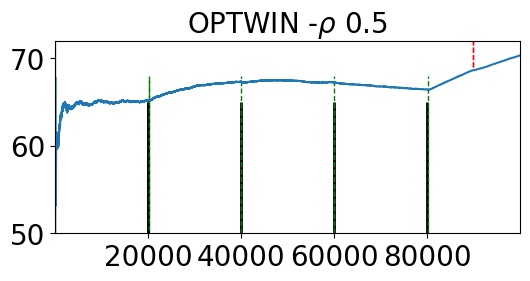

{'method': '(OPTWIN-r0.5)',
 'avg_accuracy': 69.90786666666666,
 'std_accuracy': 0.5555535750156264,
 'avg_cpu': 45.354430066666666,
 'std_cpu': 1.3893524028385948,
 'avg_ram': 4.700307181643211e-08,
 'std_ram': 1.4396990719962876e-09,
 'avg_delay': 350.89444444444445,
 'std_delay': 573.8535099614377,
 'avg_fp': 0.7666666666666667,
 'std_fp': 0.7608474807008885,
 'avg_tp': 3.7333333333333334,
 'std_tp': 0.4422166387140533}

In [10]:
method = "(OPTWIN-r0.5)"
itt = 0
name = r'OPTWIN -$\rho$ 0.5'
optwin05_output = identify_metrics(method, n_itt, name, itt, False, False, False, False)
optwin05_output

### OPTWIN -r 1.0

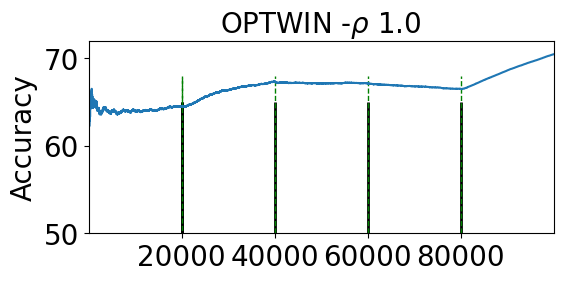

{'method': '(OPTWIN-r1.0)',
 'avg_accuracy': 69.44333333333334,
 'std_accuracy': 0.803450890430356,
 'avg_cpu': 45.35781883333333,
 'std_cpu': 1.3744699040811967,
 'avg_ram': 4.703209332797604e-08,
 'std_ram': 1.4199264866522118e-09,
 'avg_delay': 630.6333333333333,
 'std_delay': 486.7293132243546,
 'avg_fp': 0.26666666666666666,
 'std_fp': 0.5120763831912405,
 'avg_tp': 3.533333333333333,
 'std_tp': 0.4988876515698589}

In [11]:
method = "(OPTWIN-r1.0)"
itt = 1
name = r'OPTWIN -$\rho$ 1.0'
optwin10_output = identify_metrics(method, n_itt, name, itt, False, True, False, False)
optwin10_output

### ADWIN

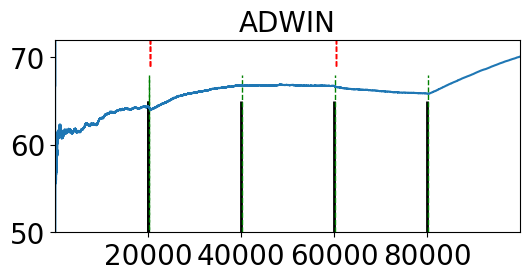

{'method': 'ADWINChangeDetector',
 'avg_accuracy': 70.22123333333333,
 'std_accuracy': 0.28970325880272635,
 'avg_cpu': 45.565803966666664,
 'std_cpu': 4.203100863305748,
 'avg_ram': 4.971159820934645e-08,
 'std_ram': 4.559018096571045e-09,
 'avg_delay': 229.4,
 'std_delay': 37.031158051925225,
 'avg_fp': 4.233333333333333,
 'std_fp': 2.1241991955139756,
 'avg_tp': 4.0,
 'std_tp': 0.0}

In [12]:
method = "ADWINChangeDetector"
itt = 4
name = 'ADWIN'
adwin_output = identify_metrics(method, n_itt, name, itt, False, False, False, False)
adwin_output

### DDM

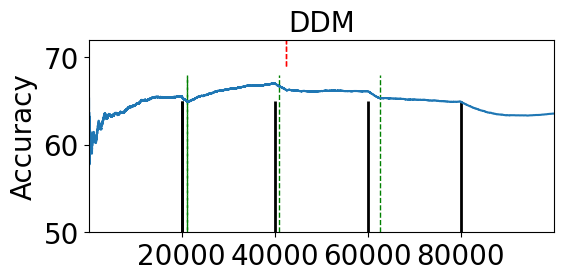

{'method': 'DDM',
 'avg_accuracy': 65.52513333333333,
 'std_accuracy': 3.5482025924095164,
 'avg_cpu': 48.560354233333335,
 'std_cpu': 2.049242939587619,
 'avg_ram': 3.3325528530956097e-08,
 'std_ram': 1.406468158571904e-09,
 'avg_delay': 1875.8666666666663,
 'std_delay': 1390.9361410308977,
 'avg_fp': 0.9,
 'std_fp': 0.9433981132056605,
 'avg_tp': 3.2,
 'std_tp': 1.0132456102380443}

In [13]:
method = "DDM"
itt=7
name = method
ddm_output = identify_metrics(method, n_itt, name, itt, False, True, False, False)
ddm_output

### EDDM

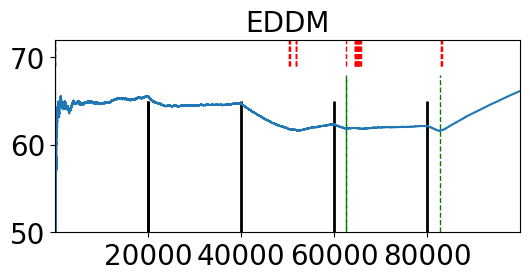

{'method': 'EDDM',
 'avg_accuracy': 65.45986666666667,
 'std_accuracy': 1.5201209963940898,
 'avg_cpu': 44.55543506666666,
 'std_cpu': 2.799341529646385,
 'avg_ram': 2.4883982528690537e-08,
 'std_ram': 1.5643323748901542e-09,
 'avg_delay': 5370.466666666668,
 'std_delay': 1022.7657622566588,
 'avg_fp': 17.2,
 'std_fp': 8.4829240241794,
 'avg_tp': 2.4,
 'std_tp': 0.5537749241945382}

In [14]:
method = "EDDM"
itt = 3
name = method
eddm_output = identify_metrics(method, n_itt, name, itt, False, False, False, False)
eddm_output

### STEPD

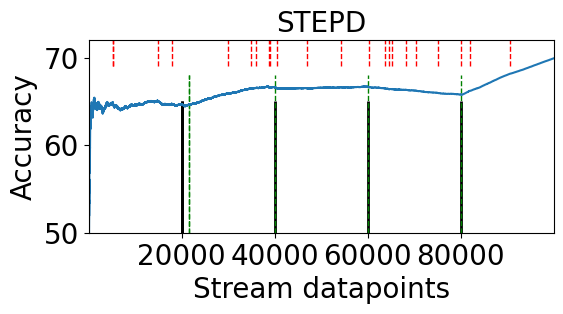

{'method': 'STEPD',
 'avg_accuracy': 69.48053333333334,
 'std_accuracy': 0.315653425543698,
 'avg_cpu': 47.62170983333333,
 'std_cpu': 4.891249530750916,
 'avg_ram': 3.40723568567384e-08,
 'std_ram': 3.499451013733021e-09,
 'avg_delay': 838.0333333333333,
 'std_delay': 1023.8833525955104,
 'avg_fp': 23.466666666666665,
 'std_fp': 4.800925836637022,
 'avg_tp': 3.966666666666667,
 'std_tp': 0.17950549357115012}

In [15]:
method = "STEPD"
itt = 3
name = method
stepd_output = identify_metrics(method, n_itt, name, itt, True, True, False, False)
stepd_output

### EWMAChartDM

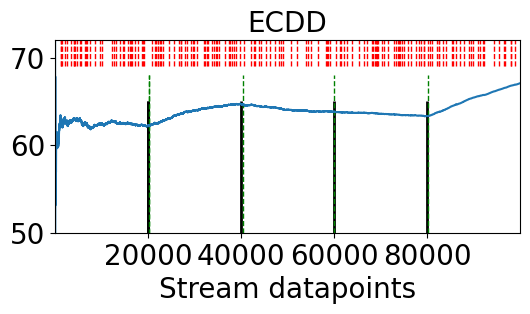

{'method': 'EWMAChartDM',
 'avg_accuracy': 67.03373333333333,
 'std_accuracy': 0.23289614872718073,
 'avg_cpu': 47.24795663333334,
 'std_cpu': 1.866611764448336,
 'avg_ram': 3.0060165934333505e-08,
 'std_ram': 1.187865104518208e-09,
 'avg_delay': 465.9,
 'std_delay': 434.8363370280823,
 'avg_fp': 153.56666666666666,
 'std_fp': 9.07260834722971,
 'avg_tp': 4.0,
 'std_tp': 0.0}

In [16]:
method = "EWMAChartDM"
itt = 0
name="ECDD"
EWMAChartDM_output = identify_metrics(method, n_itt, name, itt, True, False, False, False)
EWMAChartDM_output

### No detector

/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


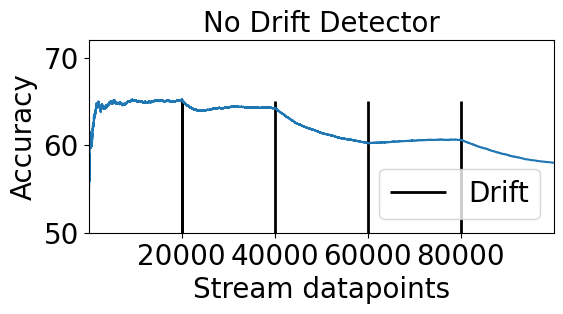

{'method': 'moa.classifiers.rules.core.changedetection.NoChangeDetection',
 'avg_accuracy': 57.937533333333334,
 'std_accuracy': 0.17460294529516818,
 'avg_cpu': 44.46571816666666,
 'std_cpu': 3.019329709601076,
 'avg_ram': 2.3558779675652412e-08,
 'std_ram': 1.599697318471353e-09,
 'avg_delay': 0,
 'std_delay': nan,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 0.0,
 'std_tp': 0.0}

In [17]:
method = "moa.classifiers.rules.core.changedetection.NoChangeDetection"
itt = 0
name = "No Drift Detector"
no_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
no_output

# GRADUAL DRIFT

In [18]:
drift_window = 1000

### OPTWIN -r 0.1

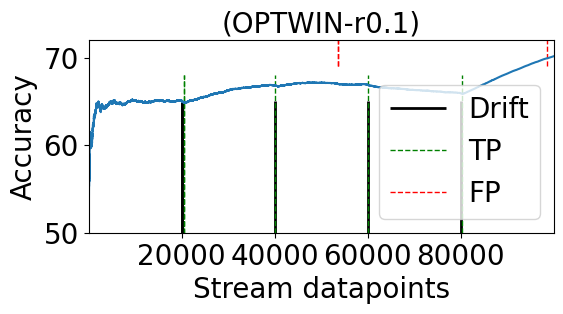

{'method': '(OPTWIN-r0.1)',
 'avg_accuracy': 69.93816666666666,
 'std_accuracy': 0.30927435463804714,
 'avg_cpu': 44.816719899999995,
 'std_cpu': 1.6021522916142945,
 'avg_ram': 4.638287831360111e-08,
 'std_ram': 1.657186839084046e-09,
 'avg_delay': 314.3861111111111,
 'std_delay': 79.68315869317047,
 'avg_fp': 0.4666666666666667,
 'std_fp': 0.6699917080747261,
 'avg_tp': 3.7,
 'std_tp': 0.5259911279353167}

In [19]:
method = "(OPTWIN-r0.1)"
itt = 0
name = method
optwin01_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
optwin01_gradual_output

### OPTWIN -r 0.5

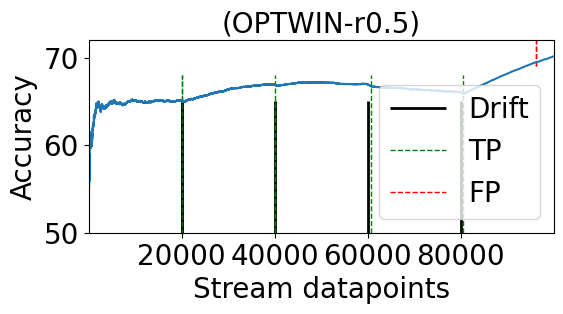

{'method': '(OPTWIN-r0.5)',
 'avg_accuracy': 69.27233333333334,
 'std_accuracy': 0.618639460113237,
 'avg_cpu': 44.2065765,
 'std_cpu': 1.9343001331844651,
 'avg_ram': 4.580680963500539e-08,
 'std_ram': 1.9994885575611546e-09,
 'avg_delay': 759.5472222222222,
 'std_delay': 826.2956575840659,
 'avg_fp': 0.5333333333333333,
 'std_fp': 0.618241233033047,
 'avg_tp': 3.5,
 'std_tp': 0.5}

In [20]:
method = "(OPTWIN-r0.5)"
itt = 0
name = method
optwin05_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
optwin05_gradual_output

### OPTWIN -r 1.0

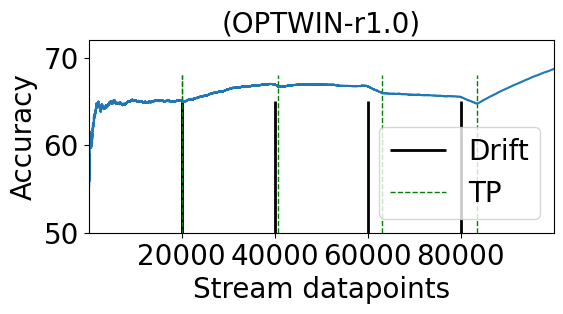

{'method': '(OPTWIN-r1.0)',
 'avg_accuracy': 68.60626666666667,
 'std_accuracy': 1.3943228719577,
 'avg_cpu': 45.627544199999996,
 'std_cpu': 1.650279600958313,
 'avg_ram': 4.731772000963536e-08,
 'std_ram': 1.7121615408714272e-09,
 'avg_delay': 1190.9194444444445,
 'std_delay': 816.5643743995817,
 'avg_fp': 0.5,
 'std_fp': 0.6708203932499369,
 'avg_tp': 3.2333333333333334,
 'std_tp': 0.6674994798166928}

In [21]:
method = "(OPTWIN-r1.0)"
itt = 0
name = method
optwin10_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
optwin10_gradual_output

### ADWIN

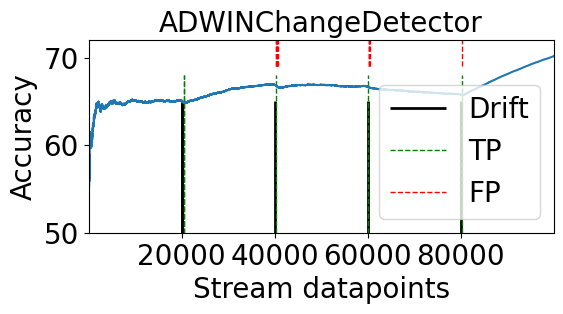

{'method': 'ADWINChangeDetector',
 'avg_accuracy': 69.8905,
 'std_accuracy': 0.3289165862185365,
 'avg_cpu': 40.46956393333333,
 'std_cpu': 12.924101673440715,
 'avg_ram': 4.426605654990754e-08,
 'std_ram': 1.4144295286867936e-08,
 'avg_delay': 324.8666666666667,
 'std_delay': 75.86467484204285,
 'avg_fp': 10.266666666666667,
 'std_fp': 2.6068286394689535,
 'avg_tp': 3.966666666666667,
 'std_tp': 0.1795054935711501}

In [22]:
method = "ADWINChangeDetector"
itt = 0
name = method
adwin_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
adwin_gradual_output

### DDM

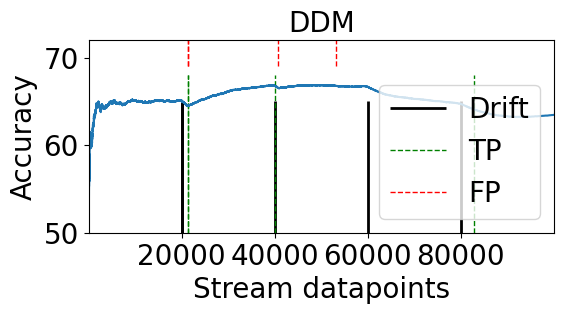

{'method': 'DDM',
 'avg_accuracy': 65.79963333333333,
 'std_accuracy': 3.072949470317798,
 'avg_cpu': 26.647075266666665,
 'std_cpu': 0.6005046656198184,
 'avg_ram': 1.8281835033868882e-08,
 'std_ram': 4.1549336499033954e-10,
 'avg_delay': 1643.5583333333336,
 'std_delay': 1211.3924865834879,
 'avg_fp': 1.0,
 'std_fp': 1.0954451150103321,
 'avg_tp': 3.1333333333333333,
 'std_tp': 0.7630348761506397}

In [23]:
method = "DDM"
itt = 0
name = method
ddm_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
ddm_gradual_output

### EDDM

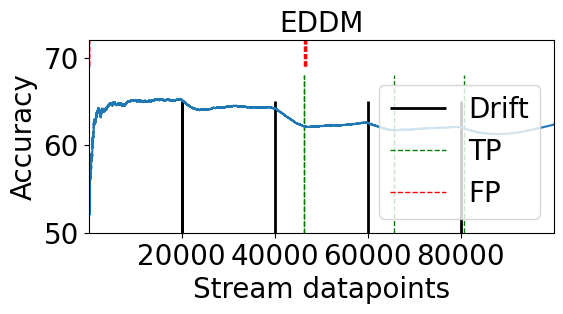

{'method': 'EDDM',
 'avg_accuracy': 65.30873333333334,
 'std_accuracy': 1.3217993987646952,
 'avg_cpu': 24.281558,
 'std_cpu': 0.3226224991543824,
 'avg_ram': 1.3560613785974014e-08,
 'std_ram': 1.7726083513817004e-10,
 'avg_delay': 5432.972222222222,
 'std_delay': 1167.7148212890102,
 'avg_fp': 16.866666666666667,
 'std_fp': 8.732060976017568,
 'avg_tp': 2.466666666666667,
 'std_tp': 0.5617433182117573}

In [24]:
method = "EDDM"
itt = 0
name = method
eddm_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
eddm_gradual_output

### STEPD

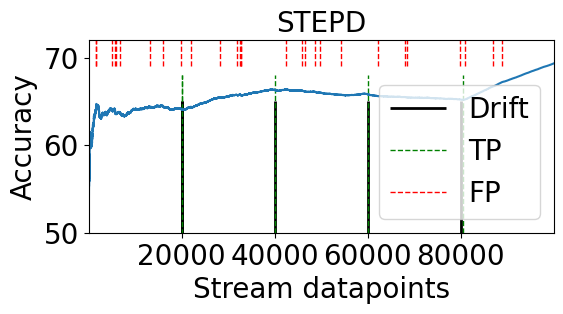

{'method': 'STEPD',
 'avg_accuracy': 69.12596666666667,
 'std_accuracy': 0.3997188221507854,
 'avg_cpu': 40.63971823333333,
 'std_cpu': 12.767194341041733,
 'avg_ram': 2.9076474501785955e-08,
 'std_ram': 9.135461306557908e-09,
 'avg_delay': 2077.525,
 'std_delay': 1537.3786799695772,
 'avg_fp': 23.333333333333332,
 'std_fp': 5.042045440317077,
 'avg_tp': 3.8,
 'std_tp': 0.39999999999999997}

In [25]:
method = "STEPD"
itt = 0
name = method
stepd_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
stepd_gradual_output

### EWMAChartDM

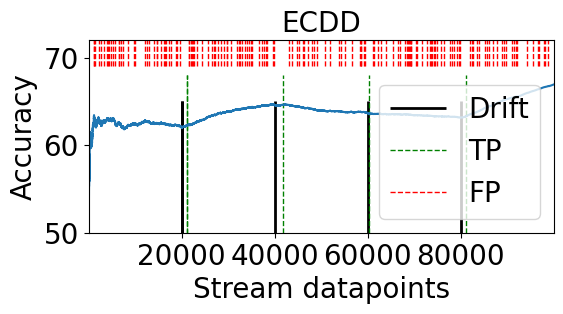

{'method': 'EWMAChartDM',
 'avg_accuracy': 66.79506666666667,
 'std_accuracy': 0.2657932737444943,
 'avg_cpu': 26.292913066666664,
 'std_cpu': 0.45532577525675716,
 'avg_ram': 1.6727817650608267e-08,
 'std_ram': 2.9023653299147756e-10,
 'avg_delay': 1165.1666666666667,
 'std_delay': 886.4491109978557,
 'avg_fp': 148.96666666666667,
 'std_fp': 10.06804626308181,
 'avg_tp': 3.933333333333333,
 'std_tp': 0.24944382578492943}

In [26]:
method = "EWMAChartDM"
itt = 0
name="ECDD"
EWMAChartDM_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
EWMAChartDM_gradual_output

/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


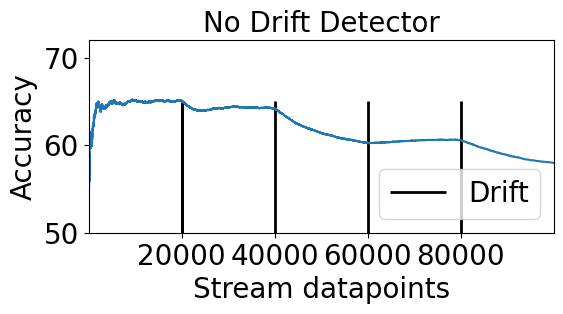

{'method': 'moa.classifiers.rules.core.changedetection.NoChangeDetection',
 'avg_accuracy': 57.932,
 'std_accuracy': 0.17296381921841542,
 'avg_cpu': 24.4759765,
 'std_cpu': 0.24210034290689933,
 'avg_ram': 1.2967835640128121e-08,
 'std_ram': 1.2827066900797578e-10,
 'avg_delay': 0,
 'std_delay': nan,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 0.0,
 'std_tp': 0.0}

In [27]:
method = "moa.classifiers.rules.core.changedetection.NoChangeDetection"
itt = 0
name = "No Drift Detector"
no_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
no_output